# PFA-GAN

In [1]:
from torch import nn, Tensor, zeros, zeros_like, cat, eye, mean, sum as tsum, arange, cuda, load
from torch.optim import Adam
from torch.utils.data import Dataset, DistributedSampler, DataLoader, RandomSampler
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets.folder import pil_loader
from collections import OrderedDict
from matplotlib import pyplot as plt

from apex import amp
from apex.parallel import DistributedDataParallel

from typing import Union
from itertools import chain

import os
import math
import h5py
import torch
import random
import itertools
import numpy as np
import torch.nn.functional as F
import torch.distributed as dist
import torchvision

## Device for PyTorch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

## Data & Dataset

In [4]:
def age2group(age, age_group):
    if isinstance(age, np.ndarray):
        groups = np.zeros_like(age)
    else:
        groups = zeros_like(age).to(age.device)

    if age_group == 4:
        section = [30, 40, 50]
    elif age_group == 5:
        section = [20, 30, 40, 50]
    elif age_group == 7:
        section = [10, 20, 30, 40, 50, 60]
    else:
        raise NotImplementedError
    
    for i, thresh in enumerate(section, 1):
        groups[age > thresh] = i
        
    return groups[0]

In [5]:
class CACD_Dataset(Dataset):
    def __init__(
            self,
            root_dir='materials',
            dataset_name='cacd',
            age_group=4,
            train=False,
            source=0,
            max_iter=200000,
            batch_size=64,
            transforms=None,
            n_images=-1
    ):
        self.root_dir = root_dir
        self.dataset_name = dataset_name
        self.age_group = age_group
        self.train = train
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.total_pairs = batch_size * max_iter
        self.transforms = transforms
        self.n_images = n_images

        self._load_meta_data()

        self.mean_ages = np.array(
            [np.mean(self.ages[self.age_groups == i])
            for i in range(self.age_group)]
        ).astype(np.float32)

        self.label_group_images = []
        self.label_group_ages = []

        for i in range(self.age_group):
            self.label_group_images.append(
                self.image_names[self.age_groups == i].tolist())
            self.label_group_ages.append(
                self.ages[self.age_groups == i].astype(np.float32).tolist())

        self.target_labels = np.random.randint(source + 1, self.age_group, self.total_pairs)

        pairs = np.array(list(itertools.combinations(range(age_group), 2)))
        p = [1, 1, 1, 0.5, 0.5, 0.5]
        p = np.array(p) / np.sum(p)
        pairs = pairs[np.random.choice(range(len(pairs)), self.total_pairs, p=p), :]
        source_labels, target_labels = pairs[:, 0], pairs[:, 1]
        self.source_labels = source_labels
        self.target_labels = target_labels

        self.true_labels = np.random.randint(0, self.age_group, self.total_pairs)

    def _load_meta_data(self):
        meta = h5py.File(os.path.join(self.root_dir, f"{self.dataset_name}.mat"), 'r')

        self.ages = meta['celebrityImageData']['age'][0,:]
        self.age_groups = np.asanyarray([age2group(np.asanyarray([age]), self.age_group) for age in self.ages])
        self.image_names = np.asanyarray(
            [''.join(chr(i[0])
                    for i in hdf5_object)
                    for hdf5_object in [meta[hdf5_object_reference][:] 
                    for hdf5_object_references in meta['celebrityImageData']['name']
                    for hdf5_object_reference in hdf5_object_references]
            ]
        )

    def __len__(self):
        if len(self.ages) == len(self.image_names) and len(self.image_names) == len(self.age_groups):
            return len(self.ages)
        else:
            return -1
    
    def __getitem__(self, idx):
        source_label = self.source_labels[idx]
        target_label = self.target_labels[idx]
        true_label = self.true_labels[idx]

        source_img = transforms.ToTensor()(pil_loader(os.path.join(self.root_dir, self.dataset_name, random.choice(self.label_group_images[source_label]))).resize((248,248)))

        index = random.randint(0, len(self.label_group_images[true_label]) - 1)
        true_img = transforms.ToTensor()(pil_loader(os.path.join(self.root_dir, self.dataset_name, self.label_group_images[true_label][index])).resize((248,248)))
        true_age = self.label_group_ages[true_label][index]
        mean_age = self.mean_ages[target_label]

        if self.transforms is not None:
            source_img = self.transforms(source_img)
            true_img = self.transforms(true_img)

        return source_img, true_img, source_label, target_label, true_label, true_age, mean_age

In [6]:
class DataPrefetcher():
    def __init__(self, loader, *norm_index):
        self.loader = iter(loader)
        self.normlize = lambda x: x.sub_(0.5).div_(0.5)
        self.norm_index = norm_index
        self.stream = cuda.Stream()
        self.preload()

    def preload(self):
        try:
            self.next_input = next(self.loader)
        except StopIteration:
            self.next_input = None
            return
        with cuda.stream(self.stream):
            self.next_input = [
                self.normlize(x.cuda(non_blocking=True)) if i in self.norm_index else x.cuda(non_blocking=True)
                for i, x in enumerate(self.next_input)
            ]

    def next(self):
        cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        self.preload()
        return input

## PFA-GAN

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, age_group, conv_dim=64, repeat_num=3):
        super(Discriminator, self).__init__()
        self.age_group = age_group
        self.conv_dim = conv_dim
        self.repeat_num = repeat_num
        self._init_model()

    def _init_model(self):
        self.conv1 = nn.Conv2d(
            3,
            self.conv_dim,
            kernel_size=4,
            stride=2,
            padding=1
        )

        layers = []
        nf_mult = 1

        # gradually increase the number of filters
        for n in range(1, self.repeat_num):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            
            layers += [
                nn.utils.spectral_norm(
                    nn.Conv2d(
                        in_channels=self.conv_dim * nf_mult_prev + (self.age_group if n == 1 else 0),
                        out_channels=self.conv_dim * nf_mult,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=True
                    )
                ),
                nn.LeakyReLU(0.2, True)
            ]
        
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** self.repeat_num, 8)
        
        layers += [
            nn.Conv2d(
                in_channels=self.conv_dim * nf_mult_prev,
                out_channels=self.conv_dim * nf_mult,
                kernel_size=4,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(self.conv_dim * nf_mult),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(
                in_channels=self.conv_dim * nf_mult,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=1

            )
        ]

        self.main = nn.Sequential(*layers)
    
    def forward(self, inputs, condition):
        x = F.leaky_relu(self.conv1(inputs), 0.2, inplace=True)
        condition = self._group2feature(
            condition.to(device),
            feature_size=x.size(2),
            age_group=self.age_group
        ).to(x)
        return self.main(cat([x, condition], dim=1))

    def _group2feature(self, group, age_group, feature_size):
        onehot = self._group2onehot(
            group, 
            age_group
        )
        return onehot.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, feature_size, feature_size).to(device)

    def _group2onehot(self, groups, age_group):
        code = eye(age_group).to(device)[groups.squeeze()]
        if len(code.size()) > 1:
            return code
        return code.unsqueeze(0).to(device)

### ResidualBlock

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.n_channels = channels
        self._init_model()
    
    def _init_model(self):
        layers = [
            nn.Conv2d(
                self.n_channels,
                self.n_channels,
                3,
                1,
                1
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                self.n_channels,
                self.n_channels,
                3,
                1,
                1
            ),
            nn.BatchNorm2d(self.n_channels),
        ]

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        x = self.main(x)
        return F.leaky_relu(residual + x, 0.2, inplace=True)

### Generator

In [9]:
class GeneratorSubNetwork(nn.Module):
    def __init__(self, in_channels=3, n_residual_blocks=4):
        super(GeneratorSubNetwork, self).__init__()

        self.in_channels = in_channels
        self.n_residual_blocks = n_residual_blocks

        self._init_model()
    
    def _init_model(self):
        layers = [
            nn.Conv2d(
                in_channels=self.in_channels,
                out_channels=32,
                kernel_size=9,
                stride=1,
                padding=4
            ),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        for _ in range(self.n_residual_blocks):
            layers.append(ResidualBlock(128))

        layers.extend([
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=32,
                out_channels=3,
                kernel_size=9,
                stride=1,
                padding=4
            )
        ])
    
        self.main = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.main(x)

In [10]:
class Generator(nn.Module):
    def __init__(self, age_group, n_residual_blocks=4):
        super(Generator, self).__init__()
        self.age_group = age_group
        self._init_model(n_residual_blocks)
    
    def _init_model(self, n_residual_blocks):
        self.sub_networks = nn.ModuleList()

        for _ in range(self.age_group - 1):
            self.sub_networks.append(GeneratorSubNetwork(
                in_channels=3,
                n_residual_blocks=n_residual_blocks
            ))
    
    def forward(self, x, source_label: Tensor, target_label: Tensor):
        condition = self._pfa_encoding(source_label, target_label, self.age_group).to(device)
        for i in range(self.age_group - 1):
            aging_effects = self.sub_networks[i](x)
            x = x + aging_effects * condition[:, i]
        return x

    def _pfa_encoding(self, source, target, age_group):
        source, target = source.long(), target.long()
        code = zeros((source.size(0), age_group - 1, 1, 1, 1)).to(source)
        for i in range(source.size(0)):
            code[i, source[i]: target[i], ...] = 1
        return code


### Age Classifier

In [11]:
"""
VGG implementation from [InterDigitalInc](https://github.com/InterDigitalInc/HRFAE/blob/master/nets.py)
"""

class AuxiliaryAgeClassifier(nn.Module):
    def __init__(self, pool='max'):
        super(AuxiliaryAgeClassifier, self).__init__()
        # vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.fc6 = nn.Linear(25088, 4096, bias=True)
        self.fc7 = nn.Linear(4096, 4096, bias=True)
        self.fc8_101 = nn.Linear(4096, 101, bias=True)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['p3'] = self.pool3(out['r33'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['p4'] = self.pool4(out['r43'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['p5'] = self.pool5(out['r53'])
        out['p5'] = out['p5'].view(out['p5'].size(0), -1)
        out['fc6'] = F.relu(self.fc6(out['p5']))
        out['fc7'] = F.relu(self.fc7(out['fc6']))
        out['fc8'] = self.fc8_101(out['fc7'])
        return out

In [12]:
#class AuxiliaryAgeClassifier(nn.Module):
#    def __init__(self, conv_dim=64, channels=3, classes=101):
#        super(AuxiliaryAgeClassifier, self).__init__()
#
#        self.conv_dim = conv_dim
#        self.channels = channels
#        self.classes = classes
#
#        self._init_model()
#
#    def _add_vgg_block(self, in_channels, out_channels, more=False):
#        layers = [
#            (
#                'conv1',
#                nn.Conv2d(
#                    in_channels,
#                    out_channels,
#                    kernel_size=3,
#                    stride=1,
#                    padding=1
#                )
#            ),
#            (
#                'relu1',
#                nn.ReLU(inplace=True)
#            ),
#            (
#                'conv2',
#                nn.Conv2d(
#                    out_channels,
#                    out_channels,
#                    kernel_size=3,
#                    stride=1,
#                    padding=1
#                )
#            ),
#            (
#                'relu2',
#                nn.ReLU(inplace=True)
#            ),
#        ]
#
#        if more:
#            layers.extend([
#                (
#                    'conv3',
#                    nn.Conv2d(
#                        out_channels,
#                        out_channels,
#                        kernel_size=3,
#                        stride=1,
#                        padding=1
#                    )
#                ),
#                (
#                    'relu3',
#                    nn.ReLU(inplace=True)
#                ),
#            ])
#
#        layers.append(('maxpool', nn.MaxPool2d(kernel_size=2, stride=2)))
#
#        return nn.Sequential(OrderedDict(layers))
#
#    def _init_model(self):
#        self.conv = nn.Sequential(
#            self._add_vgg_block(self.channels, self.conv_dim),
#            self._add_vgg_block(self.conv_dim, self.conv_dim*2),
#            self._add_vgg_block(self.conv_dim*2, self.conv_dim*4, True),
#            self._add_vgg_block(self.conv_dim*4, self.conv_dim*8, True),
#            self._add_vgg_block(self.conv_dim*8, self.conv_dim*8, True),
#        )
#
#        self.fc1 = nn.Sequential(
#            nn.Linear((self.conv_dim*8)*7*7, 4096),
#            nn.ReLU(inplace=True),
#            nn.Dropout(0.5, inplace=True),
#        )
#
#        self.fc2 = nn.Sequential(
#            nn.Linear(4096, 4096),
#            nn.ReLU(inplace=True),
#            nn.Dropout(0.5, inplace=True),
#        )
#
#        self.cls = nn.Linear(4096, self.classes)
#
#    def forward(self, x):
#        """
#        Forward operation of the net.
#        """
#        in_size = x.shape[0]
#        x = self.conv(x)
#        x = x.view(in_size, -1)
#        x = self.fc1(x)
#        x = self.fc2(x)
#        return self.cls(x)
#        #return F.softmax(x, dim=1)

#### Example

In [13]:
def get_predicted_age(age_pb):
    predict_age_pb = F.softmax(age_pb, dim=1)
    predict_age = torch.zeros(age_pb.size(0)).type_as(predict_age_pb)
    for i in range(age_pb.size(0)):
        for j in range(age_pb.size(1)):
            predict_age[i] += j * predict_age_pb[i][j]
    return predict_age

def extract_ages(age_classifier : AuxiliaryAgeClassifier, x):
    x = F.interpolate(x, size=(224, 224), mode='bilinear')
    predict_age_pb = age_classifier(x)['fc8']
    predicted_age = get_predicted_age(predict_age_pb)
    return predicted_age

In [14]:
age_classifier = AuxiliaryAgeClassifier()
ckpt = torch.load(
    os.path.join(
            'materials',
            'models',
            'dex_age_classifier.pth'
        ),
    map_location="cpu"
)['state_dict']
ckpt = {k.replace('-', '_'): v for k, v in ckpt.items()}
age_classifier.load_state_dict(ckpt)
age_classifier.cuda()
age_classifier.eval()

AuxiliaryAgeClassifier(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3

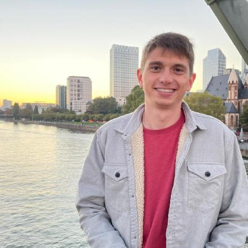

In [15]:
test_img_path = '/home/js07987/Documents/semester-6/ai-seminar/face-aging/02_PFA-GAN/materials/test/43849636.jpg'
image = pil_loader(test_img_path).resize((248,248))
image

In [16]:
image_tensor = transforms.ToTensor()(image)
image_tensor = image_tensor[None,:].to(device=device)

In [17]:
age_logit = extract_ages(age_classifier=age_classifier, x=image_tensor)
age_logit

tensor([41.7360], device='cuda:0', grad_fn=<CopySlices>)

### VGG Faces

In [18]:
def _normalize(input, mean, std):
    mean = Tensor(mean).to(input.device)
    std = Tensor(std).to(input.device)
    return input.sub(mean[None, :, None, None]).div(std[None, :, None, None])

def extract_vgg_face(vgg_face, inputs):
    inputs = _normalize((F.hardtanh(inputs) * 0.5 + 0.5) * 255,
                        [129.1863, 104.7624, 93.5940],
                        [1.0, 1.0, 1.0])
    return vgg_face(inputs)

In [19]:
vgg_face = torchvision.models.vgg16(num_classes=512)
#vgg_face = vgg_face.features[:23]
vgg_face.cuda()
vgg_face.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
extract_vgg_face(vgg_face, image_tensor).shape

torch.Size([1, 512])

In [21]:
from facenet_pytorch import InceptionResnetV1

In [22]:
vgg_face_2 = InceptionResnetV1(pretrained='vggface2')

vgg_face_2.cuda()
vgg_face_2.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [23]:
extract_vgg_face(vgg_face_2, image_tensor).shape

torch.Size([1, 512])

### PFA-GAN

In [24]:
class PFA_GAN(object):
    def __init__(
            self,
            alpha_fea,
            alpha_ssim,
            pix_loss_weight,
            gan_loss_weight,
            id_loss_weight,
            age_loss_weight,
            age_group=4,
            image_size=256,
            pretrained_image_size=256,
            init_lr=1e-4,
            restore_iter=0,
            max_iter=200000,
            save_iter=10,
            decay_pix_factor=0.,
            decay_pix_n=2000,
            num_workers=0,
            batch_size=64,
            experiment=0):
        
        self.age_group = age_group
        self.image_size = image_size
        self.pretrained_image_size = pretrained_image_size
        self.init_lr = init_lr
        self.restore_iter = restore_iter
        self.max_iter = max_iter
        self.save_iter = save_iter
        self.pix_loss_weight = pix_loss_weight
        self.decay_pix_factor = decay_pix_factor
        self.decay_pix_n = decay_pix_n
        self.gan_loss_weight = gan_loss_weight
        self.alpha_fea = alpha_fea
        self.alpha_ssim = alpha_ssim
        self.id_loss_weight = id_loss_weight
        self.age_loss_weight = age_loss_weight
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.experiment = experiment

        self.test_images = self._get_test_images()
        self.prefetcher = self._get_train_loader()

        self._init_model()
    
    def fit(self):
        for n_iter in range(self.restore_iter + 1, self.max_iter + 1):
            inputs = self.prefetcher.next()

            d1_logit, d3_logit, g_loss, d_loss, gan_logit, age_loss, l1_loss, ssim_loss, id_loss, total_loss = self.train(inputs, n_iter=n_iter)

            if d1_logit is None:
                self.prefetcher = self._get_train_loader()

            if n_iter % 50 == 0:
                print(f'[{n_iter}/{self.max_iter + 1}]\tG: {g_loss}\tD: {d_loss}\tAge: {age_loss}\tL1: {l1_loss}\tSSIMM: {ssim_loss}\tID: {id_loss}\tTotal: {total_loss}')
            
            if n_iter % self.save_iter == 0 or n_iter == self.max_iter:
                self._save_model(os.path.join('model', 'pfa-gan', 'checkpoint', f'exp_{self.experiment}'), n_epoch=n_iter, is_checkpoint=True)
                self.generate_images(n_iter)
        
        self._save_model(os.path.join('model', 'pfa-gan'), is_checkpoint=False)

    def train(self, inputs, n_iter):
        try:
            source_img, true_img, source_label, target_label, true_label, true_age, mean_age = inputs
            source_img, true_img, source_label, target_label, true_label, true_age, mean_age = source_img.to(device), true_img.to(device), source_label.to(device), target_label.to(device), true_label.to(device), true_age.to(device), mean_age.to(device)
        except:
            return [
                None,
                None,
                None,
                None,
                None,
                None,
                None,
                None,
                None,
                None
            ]
        
        self.generator.train()
        self.discriminator.train()

        if self.image_size < self.pretrained_image_size:
            source_img_small = F.interpolate(source_img, self.image_size)
            true_img_small = F.interpolate(true_img, self.image_size)
        else:
            source_img_small = source_img
            true_img_small = true_img
        
        g_source = self.generator(source_img_small, source_label, target_label)
        
        if self.image_size < self.pretrained_image_size:
            g_source_pretrained = F.interpolate(g_source, self.pretrained_image_size)
        else:
            g_source_pretrained = g_source

        ###########################
        # Train Discriminator
        ###########################
        self.discriminator_optimizer.zero_grad()
        d1_logit = self.discriminator(true_img_small, true_label)
        # d2_logit = self.discriminator(true_img, source_label)
        d3_logit = self.discriminator(g_source.detach(), target_label)

        # d_loss = 0.5 * (ls_gan(d1_logit, 1.) + ls_gan(d2_logit, 0.) + ls_gan(d3_logit, 0.))
        d_loss = 0.5 * (self._ls_gan(d1_logit, 1.) + self._ls_gan(d3_logit, 0.))

        # COMMENT IN 
        with amp.scale_loss(d_loss, self.discriminator_optimizer) as scaled_loss:
            scaled_loss.backward()
        self.discriminator_optimizer.step()

        ###########################
        # Train Generator
        ###########################
        self.optimizer_generator.zero_grad()

        ###########################
        # GAN Loss
        ###########################
        gan_logit = self.discriminator(g_source, target_label)
        g_loss = self._ls_gan(gan_logit, 1.)

        ###########################
        # Age Loss
        ###########################
        age_loss = self._age_criterion(g_source_pretrained, mean_age)

        ###########################
        # L1 Loss
        ###########################
        l1_loss = F.l1_loss(g_source_pretrained, source_img)

        ###########################
        # SSIM Loss
        ###########################
        ssim_loss = self._compute_ssim_loss(g_source_pretrained, source_img, window_size=10)

        ###########################
        # ID Loss
        ###########################
        id_loss = F.mse_loss(
            self._extract_vgg_face(g_source_pretrained),
            self._extract_vgg_face(source_img)
        )

        ###########################
        # Pixel-Wise Loss
        ###########################
        pix_loss_weight = max(
            self.pix_loss_weight,
            self.pix_loss_weight * (self.decay_pix_factor ** (n_iter // self.decay_pix_n))
        )

        ###########################
        # Total Loss
        ###########################
        total_loss = \
            g_loss * self.gan_loss_weight + \
            age_loss * self.age_loss_weight + \
            id_loss * self.id_loss_weight + \
            (l1_loss * (1 - self.alpha_fea) + ssim_loss * self.alpha_ssim) * pix_loss_weight
        
        with amp.scale_loss(total_loss, self.optimizer_generator) as scaled_loss:
            scaled_loss.backward()
        self.optimizer_generator.step()

        return [
            d1_logit,
            d3_logit,
            d_loss,
            g_loss,
            gan_logit,
            age_loss,
            l1_loss,
            ssim_loss,
            id_loss,
            total_loss
        ]
    
    @torch.no_grad()
    def generate_images(self, n_iter, n_source=0, age_group=4):
        self.generator.eval()
        
        real_img = self.test_images[0].to(device)
        bs, ch, w, h = real_img.size()
        fake_imgs = [real_img, ]

        for target in range(n_source + 1, age_group):
            output = self.generator(real_img, torch.ones(bs) * n_source, torch.ones(bs) * target)
            fake_imgs.append(output)
            
        fake_imgs = torch.stack(fake_imgs).transpose(1, 0).reshape((-1, ch, w, h))

        fake_imgs = fake_imgs * 0.5 + 0.5
        grid_img = torchvision.utils.make_grid(fake_imgs.clamp(0., 1.), nrow=age_group - n_source)

        self._save_image(
            grid_img,
            os.path.join(
                'materials',
                'test_generations',
                f'exp_{self.experiment}'
            ),
            f'{n_iter}_{self.experiment}_test.jpg'
        )
    
    def _save_image(self, grid_img, path, img_name):
        if not os.path.exists(path):
            os.mkdir(path)
        
        save_image(
            grid_img,
            os.path.join(path, img_name),
            nrow=1
        )

    def _ls_gan(self, inputs, targets):
        return mean((inputs - targets) ** 2)
    
    def _age_criterion(self, input, gt_age):
        #age_logit, group_logit = self.age_classifier(input)
        #age_logit = self.age_classifier(input)
        #age_logit = self._extract_ages(input) / 100.
        age_logit = self._extract_ages(input)
        #return F.mse_loss(self._get_dex_age(age_logit), gt_age)# + \
               #F.cross_entropy(group_logit, age2group(gt_age, self.age_group).long())
        return F.mse_loss(age_logit, gt_age)
        
    def _extract_ages(self, x):
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        predict_age_pb = self.age_classifier(x)['fc8']
        predicted_age = self.__get_predicted_age(predict_age_pb)
        return predicted_age

    def __get_predicted_age(self, age_pb):
        predict_age_pb = F.softmax(age_pb, dim=1)
        predict_age = torch.zeros(age_pb.size(0)).type_as(predict_age_pb)
        for i in range(age_pb.size(0)):
            for j in range(age_pb.size(1)):
                predict_age[i] += j * predict_age_pb[i][j]
        return predict_age
    
    def _compute_ssim_loss(self, img1, img2, window_size=11):
        channel = img1.size(1)
        window = self._create_window(window_size, channel).to(img1.device)

        mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        return 1.0 - ssim_map.mean()

    def _create_window(self, window_size, channel):
        _1D_window = self._gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window
    
    def _gaussian(self, window_size, sigma):
        gauss = Tensor([math.exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
        return gauss / gauss.sum()
    
    def _extract_vgg_face(self, inputs):
        inputs = self._normalize((F.hardtanh(inputs) * 0.5 + 0.5) * 255,
                           [129.1863, 104.7624, 93.5940],
                           [1.0, 1.0, 1.0])
        return self.vgg_face(inputs)
    
    def _normalize(self, input, mean, std):
        mean = Tensor(mean).to(input.device)
        std = Tensor(std).to(input.device)
        return input.sub(mean[None, :, None, None]).div(std[None, :, None, None])

    def _init_model(self):
        self.generator = Generator(self.age_group)
        self.generator.apply(self._weights_init)

        self.discriminator = Discriminator(
            age_group=self.age_group,
            repeat_num=int(np.log2(self.image_size) - 4),

        )

        #self.vgg_face = torchvision.models.vgg16(num_classes=2622)
        #self.vgg_face.load_state_dict()
        #self.vgg_face = self.vgg_face.features[:23]
        #self.vgg_face.cuda()
        #self.vgg_face.eval()

        self.vgg_face = InceptionResnetV1(pretrained='vggface2')
        self.vgg_face.cuda()
        self.vgg_face.eval()

        self.age_classifier = AuxiliaryAgeClassifier()
        ckpt = torch.load(
            os.path.join(
                    'materials',
                    'models',
                    'dex_age_classifier.pth'
                ),
            map_location="cpu"
        )['state_dict']
        ckpt = {k.replace('-', '_'): v for k, v in ckpt.items()}
        self.age_classifier.load_state_dict(ckpt)
        self.age_classifier.cuda()
        self.age_classifier.eval()

        self.discriminator_optimizer = Adam(
            self.discriminator.parameters(),
            self.init_lr,
            betas=(0.5, 0.99)
        )

        self.optimizer_generator = Adam(
            self.generator.parameters(),
            self.init_lr,
            betas=(0.5, 0.99)
        )

        if self.restore_iter > 0:
            self._load_model(
                os.path.join(
                    'model',
                    'pfa-gan',
                    'checkpoint',
                    f'exp_{self.experiment}'
                ),
                self.restore_iter,
                is_checkpoint=True
            )

        self.generator, self.optimizer_generator = self._to_ddp(self.generator, self.optimizer_generator)
        self.discriminator, self.discriminator_optimizer = self._to_ddp(self.discriminator, self.discriminator_optimizer)
        self.vgg_face = self._to_ddp(self.vgg_face)
        self.age_classifier = self._to_ddp(self.age_classifier)
    
    def _to_ddp(self, modules: Union[list, nn.Module], optimizer: torch.optim.Optimizer = None, opt_level: int = 0) -> Union[DistributedDataParallel, tuple]:
        if isinstance(modules, list):
            modules = [x.cuda() for x in modules]
        else:
            modules = modules.cuda()

        if optimizer is not None:
            modules, optimizer = amp.initialize(
                modules,
                optimizer,
                opt_level="O{}".format(opt_level), verbosity=1
            )
        
        #if isinstance(modules, list):
        #    modules = [DistributedDataParallel(x, delay_allreduce=True) for x in modules]
        #else:
        #    modules = DistributedDataParallel(modules, delay_allreduce=True)
        
        if optimizer is not None:
            return modules, optimizer
        else:
            return modules

    def _load_network(self, state_dict):
        if isinstance(state_dict, str):
            state_dict = load(state_dict, map_location=device)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            namekey = k.replace('module.', '')  # remove `module.`
            new_state_dict[namekey] = v
        return new_state_dict

    def _get_train_loader(self):
        train_dataset = CACD_Dataset(
            'materials',
            'cacd',
            age_group=self.age_group
        )

        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

        return DataPrefetcher(train_loader, [0, 1])

    def _get_test_images(self):
        test_dataset = CACD_Dataset(
            'materials',
            'cacd'
        )

        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

        return next(iter(test_loader))

    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            # torch.nn.init.kaiming_normal(m.weight.data, mode='fan_in')
            # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            # m.weight.data.normal_(0, math.sqrt(2. / n))
            m.weight.data.normal_(0, 0.02)
            if hasattr(m.bias, 'data'):
                m.bias.data.fill_(0)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)
        elif classname.find('Linear') != -1:
            m.bias.data.zero_()
    
    def _save_model(self, path, n_epoch=0, is_checkpoint=False):
        if not os.path.exists(path):
            os.makedirs(path)
        
        path = os.path.join(path, 'pfa-gan.obj') if not is_checkpoint else os.path.join(path, f'pfa-gan_{n_epoch}.obj')

        torch.save({
            'discriminator_state_dict': self.discriminator.state_dict(),
            'discriminator_optimizer_state_dict': self.discriminator_optimizer.state_dict(),
            'generator_state_dict': self.generator.state_dict(),
            'generator_optimizer_state_dict': self.optimizer_generator.state_dict()
        }, path)
    
    def _load_model(self, path, n_epoch=0, is_checkpoint=True):
        path = os.path.join(path, 'pfa-gan.obj') if not is_checkpoint else os.path.join(path, f'pfa-gan_{n_epoch}.obj')

        checkpoint = torch.load(path)

        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.optimizer_generator.load_state_dict(checkpoint['generator_optimizer_state_dict'])

In [25]:
pfa_gan = PFA_GAN(
    alpha_fea=0.025,
    alpha_ssim=0.15,
    gan_loss_weight=100,
    id_loss_weight=0.02,
    age_loss_weight=0.4,
    pix_loss_weight=0.,
    decay_pix_factor=0.7,
    decay_pix_n=15,
    batch_size=8,
    save_iter=5000,
    restore_iter=90000,
    num_workers=4,
    experiment=15
)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additi

/home/js07987/.local/lib/python3.11/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.amp is deprecated and will be removed by the end of February 2023. Use [PyTorch AMP](https://pytorch.org/docs/stable/amp.html)
  warnings.warn(msg, DeprecatedFeatureWarning)


In [26]:
pfa_gan.fit()

[90050/200001]	G: 0.00429251603782177	D: 1.0844029188156128	Age: 20.362262725830078	L1: 0.04578359052538872	SSIMM: 0.24083811044692993	ID: 4.851025732932612e-05	Total: 116.58519744873047
[90100/200001]	G: 0.0013062522048130631	D: 0.9678658843040466	Age: 12.637874603271484	L1: 0.05130112171173096	SSIMM: 0.23564589023590088	ID: 2.648632653290406e-05	Total: 101.84174346923828
[90150/200001]	G: 0.3518776297569275	D: 0.7375348806381226	Age: 13.744125366210938	L1: 0.03860979527235031	SSIMM: 0.15752458572387695	ID: 7.796774298185483e-06	Total: 79.25113677978516
[90200/200001]	G: 0.0006684573600068688	D: 0.9820924401283264	Age: 5.79513692855835	L1: 0.0539524108171463	SSIMM: 0.27862656116485596	ID: 3.5736891732085496e-05	Total: 100.52729797363281
[90250/200001]	G: 0.05538078397512436	D: 0.5206849575042725	Age: 7.127970218658447	L1: 0.03990718349814415	SSIMM: 0.19221532344818115	ID: 1.2144275387981907e-05	Total: 54.91968536376953
[90300/200001]	G: 0.07837117463350296	D: 0.4829255938529968	Age: 7

/home/js07987/.local/lib/python3.11/site-packages/apex/amp/_initialize.py:27: UserWarning: An input tensor was not cuda.
  warnings.warn("An input tensor was not cuda.")


[95050/200001]	G: 0.003696457715705037	D: 1.098630428314209	Age: 35.31121063232422	L1: 0.04649418592453003	SSIMM: 0.24576860666275024	ID: 2.314101584488526e-05	Total: 123.9875259399414
[95100/200001]	G: 0.0016407048096880317	D: 0.9278739094734192	Age: 22.593524932861328	L1: 0.04125931113958359	SSIMM: 0.18931549787521362	ID: 2.6922354663838632e-05	Total: 101.82479858398438
[95150/200001]	G: 0.002232476370409131	D: 0.9008418917655945	Age: 8.702430725097656	L1: 0.045067157596349716	SSIMM: 0.2268075942993164	ID: 3.584744990803301e-05	Total: 93.5651626586914
[95200/200001]	G: 0.012204347178339958	D: 0.7243245840072632	Age: 23.583402633666992	L1: 0.03895020857453346	SSIMM: 0.161493718624115	ID: 2.2585008991882205e-05	Total: 81.86581420898438
[95250/200001]	G: 0.016038870438933372	D: 0.6812671422958374	Age: 11.065258026123047	L1: 0.04295603558421135	SSIMM: 0.2047410011291504	ID: 1.4090953300183173e-05	Total: 72.55281829833984
[95300/200001]	G: 0.0018097792053595185	D: 1.0782976150512695	Age: 

KeyboardInterrupt: 